In [1]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
from model_utils import tune_model, pre_process_for_ML, eval_model, get_feature_importance 

/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Import Cleaned Data

In [2]:
df = pd.read_csv("../../data/cleaned_data/2023_cleaned_ML_data.csv")
df = df[df["5_gw_fpl_pts"].notna()]
df = df[df["minutes"] >= 60] # filter out players with minutes less than 60 since won't be selecting them for FPL team anyways 
df.head()

,name,position,team,GW,minutes,goals_scored,assists,clean_sheets,saves,penalties_saved,...,yellow_cards,red_cards,own_goals,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,team_standing,sched_strength,5_gw_fpl_pts
0,Aaron Cresswell,DEF,West Ham,5,86.2,0.0,0.0,0.2,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,17.0,13.25,2.25
1,Aaron Hickey,DEF,Brentford,5,77.8,0.0,0.0,0.2,0.0,0.0,...,0.4,0.0,0.0,0.0,0.0,0.0,0.0,8.2,9.00,1.00
2,Aaron Ramsdale,GK,Arsenal,5,90.0,0.0,0.0,0.4,1.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,6.25,2.75
5,Adam Armstrong,FWD,Southampton,5,60.8,0.2,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,14.00,1.75
8,Adam Smith,DEF,Bournemouth,5,81.0,0.0,0.0,0.4,0.0,0.0,...,0.8,0.0,0.0,0.0,0.0,0.0,0.0,12.2,14.50,3.25


## Split data by FWD, MID, DEF, and GK for separate models 

In [3]:
df_fwd = df[df["position"] == "FWD"]
df_mid = df[df["position"] == "MID"]
df_def = df[df["position"] == "DEF"] 
df_gk = df[df["position"] == "GK"] 

In [4]:
print(f"df_fwd size: {len(df_fwd)}")
print(f"df_mid size: {len(df_mid)}")
print(f"df_def size: {len(df_def)}")
print(f"df_gk size: {len(df_gk)}")

df_fwd size: 462
df_mid size: 2463
df_def size: 2181
df_gk size: 627


# FWD Model

## Tuning 

In [25]:
best_trial = tune_model(df_fwd, 200)
best_trial

[I 2023-08-13 00:48:59,562] A new study created in memory with name: no-name-49109ff0-5dcc-4c0a-b49b-48585c984fd0
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2023-08-13 00:48:59,963] Trial 0 finished with value: 1.7510374698586955 and parameters: {'n_estimators': 452, 'max_depth': 9, 'learning_rate': 0.08946526208579837, 'subsample': 0.775149744105324, 'colsample_bytree': 0.5948526401151448, 'gamma': 1.0939828892600933, 'reg_alpha': 4.134171967069449, 'reg_lambda': 4.752081272040706}. Best is trial 0 with value: 1.7510374698586955.
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

FrozenTrial(number=154, state=TrialState.COMPLETE, values=[1.4950360430666494], datetime_start=datetime.datetime(2023, 8, 13, 0, 49, 38, 267497), datetime_complete=datetime.datetime(2023, 8, 13, 0, 49, 38, 570971), params={'n_estimators': 204, 'max_depth': 9, 'learning_rate': 0.056175539398791066, 'subsample': 0.8780459557004111, 'colsample_bytree': 0.9553786363906626, 'gamma': 0.0027280282530851006, 'reg_alpha': 3.8950143870236205, 'reg_lambda': 3.5206950153637697}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_alpha': FloatD

In [26]:
# optimised params
best_trial.params

{'n_estimators': 204,
 'max_depth': 9,
 'learning_rate': 0.056175539398791066,
 'subsample': 0.8780459557004111,
 'colsample_bytree': 0.9553786363906626,
 'gamma': 0.0027280282530851006,
 'reg_alpha': 3.8950143870236205,
 'reg_lambda': 3.5206950153637697}

## Create FWD Model

In [5]:
fwd_params = {'n_estimators': 864,
 'max_depth': 10,
 'learning_rate': 0.06849279820151356,
 'subsample': 0.875985715186375,
 'colsample_bytree': 0.9633774251890509,
 'gamma': 0.007854285476974587,
 'reg_alpha': 3.629813761710702,
 'reg_lambda': 1.3156115894992295}

#fwd_params = best_trial.params

X_train_fwd, X_test_fwd, y_train_fwd, y_test_fwd = pre_process_for_ML(df_fwd)

fwd_model = xgb.XGBRegressor(**fwd_params, random_state=42)
fwd_model.fit(X_train_fwd, y_train_fwd)

/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9633774251890509,
             enable_categorical=False, gamma=0.007854285476974587, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.06849279820151356, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=864, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=3.629813761710702,
             reg_lambda=1.3156115894992295, scale_pos_weight=1,
             subsample=0.875985715186375, tree_method='exact',
             validate_parameters=1, verbosity=None)

# MID Model

## Tuning

In [8]:
best_trial = tune_model(df_mid, 200)
best_trial

[I 2023-08-13 00:38:22,919] A new study created in memory with name: no-name-1f66b2e0-1c64-491e-965f-e6b18654c599
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2023-08-13 00:38:23,696] Trial 0 finished with value: 1.5965801081850708 and parameters: {'n_estimators': 272, 'max_depth': 10, 'learning_rate': 0.035312715706962865, 'subsample': 0.6922372154357059, 'colsample_bytree': 0.6563711355132639, 'gamma': 4.134251468353929, 'reg_alpha': 1.8056409573211119, 'reg_lambda': 2.4839524904767845}. Best is trial 0 with value: 1.5965801081850708.
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with

FrozenTrial(number=173, state=TrialState.COMPLETE, values=[1.4534521064148378], datetime_start=datetime.datetime(2023, 8, 13, 0, 42, 7, 457454), datetime_complete=datetime.datetime(2023, 8, 13, 0, 42, 8, 769584), params={'n_estimators': 464, 'max_depth': 10, 'learning_rate': 0.04976929091168434, 'subsample': 0.8440305201504978, 'colsample_bytree': 0.8458844158739336, 'gamma': 0.0012470023845231448, 'reg_alpha': 0.47601387192646777, 'reg_lambda': 1.6049908956729046}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_alpha': FloatDi

In [9]:
best_trial.params

{'n_estimators': 464,
 'max_depth': 10,
 'learning_rate': 0.04976929091168434,
 'subsample': 0.8440305201504978,
 'colsample_bytree': 0.8458844158739336,
 'gamma': 0.0012470023845231448,
 'reg_alpha': 0.47601387192646777,
 'reg_lambda': 1.6049908956729046}

## Create MID Model 

In [6]:
mid_params = {'n_estimators': 436,
 'max_depth': 9,
 'learning_rate': 0.0690536094315812,
 'subsample': 0.8556738902374227,
 'colsample_bytree': 0.8592117973672548,
 'gamma': 0.0021841142688882598,
 'reg_alpha': 0.7109289789032766,
 'reg_lambda': 4.881195114910257}

#mid_params = best_trial.params

X_train_mid, X_test_mid, y_train_mid, y_test_mid = pre_process_for_ML(df_mid)

mid_model = xgb.XGBRegressor(**mid_params, random_state=42)
mid_model.fit(X_train_mid, y_train_mid)

/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8592117973672548,
             enable_categorical=False, gamma=0.0021841142688882598, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.0690536094315812, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=436, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0.7109289789032766,
             reg_lambda=4.881195114910257, scale_pos_weight=1,
             subsample=0.8556738902374227, tree_method='exact',
             validate_parameters=1, verbosity=None)

# DEF Model

## Tuning

In [11]:
best_trial = tune_model(df_def, 200)
best_trial

[I 2023-08-13 00:42:44,358] A new study created in memory with name: no-name-4e314135-14ac-409a-9cce-f3cabcf4d1a2
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2023-08-13 00:42:44,621] Trial 0 finished with value: 1.383608809490633 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.08661764387690907, 'subsample': 0.8448809283236164, 'colsample_bytree': 0.5165578419584287, 'gamma': 3.175295497858885, 'reg_alpha': 2.069606291235921, 'reg_lambda': 0.783694102427353}. Best is trial 0 with value: 1.383608809490633.
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

FrozenTrial(number=146, state=TrialState.COMPLETE, values=[1.277258655602412], datetime_start=datetime.datetime(2023, 8, 13, 0, 45, 40, 800075), datetime_complete=datetime.datetime(2023, 8, 13, 0, 45, 42, 344099), params={'n_estimators': 885, 'max_depth': 10, 'learning_rate': 0.05180483289672054, 'subsample': 0.9643747493308383, 'colsample_bytree': 0.8385646472415362, 'gamma': 0.008469264817685507, 'reg_alpha': 2.8027398932249787, 'reg_lambda': 2.066948316243687}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_alpha': FloatDist

In [12]:
best_trial.params

{'n_estimators': 885,
 'max_depth': 10,
 'learning_rate': 0.05180483289672054,
 'subsample': 0.9643747493308383,
 'colsample_bytree': 0.8385646472415362,
 'gamma': 0.008469264817685507,
 'reg_alpha': 2.8027398932249787,
 'reg_lambda': 2.066948316243687}

## Create DEF Model

In [7]:
def_params = {'n_estimators': 879,
 'max_depth': 10,
 'learning_rate': 0.07174385576894203,
 'subsample': 0.9535708448423603,
 'colsample_bytree': 0.9076537037058279,
 'gamma': 0.10394835372984072,
 'reg_alpha': 0.10130257962575871,
 'reg_lambda': 4.540798451507432}

#def_params = best_trial.params

X_train_def, X_test_def, y_train_def, y_test_def = pre_process_for_ML(df_def)

def_model = xgb.XGBRegressor(**def_params, random_state=42)
def_model.fit(X_train_def, y_train_def)

/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9076537037058279,
             enable_categorical=False, gamma=0.10394835372984072, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.07174385576894203, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=879, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0.10130257962575871,
             reg_lambda=4.540798451507432, scale_pos_weight=1,
             subsample=0.9535708448423603, tree_method='exact',
             validate_parameters=1, verbosity=None)

# GK Model 

## Tuning 

In [14]:
best_trial = tune_model(df_gk, 200)
best_trial

[I 2023-08-13 00:47:23,659] A new study created in memory with name: no-name-99d4b06c-51dc-49e3-8c9b-44f0e2f2902e
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2023-08-13 00:47:23,835] Trial 0 finished with value: 1.202708768278823 and parameters: {'n_estimators': 434, 'max_depth': 4, 'learning_rate': 0.09059004159715249, 'subsample': 0.5205616577586629, 'colsample_bytree': 0.77531961426648, 'gamma': 1.1888721008563148, 'reg_alpha': 0.6465307008143867, 'reg_lambda': 2.673752854461414}. Best is trial 0 with value: 1.202708768278823.
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

FrozenTrial(number=192, state=TrialState.COMPLETE, values=[1.076776028702501], datetime_start=datetime.datetime(2023, 8, 13, 0, 48, 55, 305381), datetime_complete=datetime.datetime(2023, 8, 13, 0, 48, 55, 703951), params={'n_estimators': 646, 'max_depth': 5, 'learning_rate': 0.04419554859102012, 'subsample': 0.6608356613652043, 'colsample_bytree': 0.9765215925543633, 'gamma': 0.0010553970934300827, 'reg_alpha': 1.7528080614120198, 'reg_lambda': 0.5741306760653008}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_alpha': FloatDis

In [15]:
best_trial.params

{'n_estimators': 646,
 'max_depth': 5,
 'learning_rate': 0.04419554859102012,
 'subsample': 0.6608356613652043,
 'colsample_bytree': 0.9765215925543633,
 'gamma': 0.0010553970934300827,
 'reg_alpha': 1.7528080614120198,
 'reg_lambda': 0.5741306760653008}

## Create GK Model 

In [8]:
gk_params = {'n_estimators': 627,
 'max_depth': 6,
 'learning_rate': 0.05660429498352957,
 'subsample': 0.9477581126623729,
 'colsample_bytree': 0.7438579854258847,
 'gamma': 0.0007775878663839263,
 'reg_alpha': 0.03056510643451671,
 'reg_lambda': 4.040396184552521}

#gk_params = best_trial.params

X_train_gk, X_test_gk, y_train_gk, y_test_gk = pre_process_for_ML(df_gk)

gk_model = xgb.XGBRegressor(**gk_params, random_state=42)
gk_model.fit(X_train_gk, y_train_gk)

/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7438579854258847,
             enable_categorical=False, gamma=0.0007775878663839263, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05660429498352957, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=627, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0.03056510643451671,
             reg_lambda=4.040396184552521, scale_pos_weight=1,
             subsample=0.9477581126623729, tree_method='exact',
             validate_parameters=1, verbosity=None)

# Evaluate Models

### FWD Model Performance 

In [9]:
eval_model(fwd_model, X_test_fwd, y_test_fwd)

rmse: 1.48
R2 score: 0.60


1. goals_scored: 0.23304040729999542
2. bonus: 0.16301091015338898
3. expected_goal_involvements: 0.06797520816326141
4. assists: 0.06569196283817291
5. team_standing: 0.06497535854578018
6. expected_assists: 0.060562703758478165
7. minutes: 0.05196640267968178
8. expected_goals: 0.049172867089509964
9. penalties_missed: 0.04168475419282913
10. yellow_cards: 0.04130763188004494
11. GW: 0.03910694271326065
12. sched_strength: 0.02872508578002453
13. expected_goals_conceded: 0.027774659916758537
14. goals_conceded: 0.02759426087141037
15. red_cards: 0.02270341105759144
16. clean_sheets: 0.014707474038004875
17. penalties_saved: 0.0
18. saves: 0.0
19. own_goals: 0.0


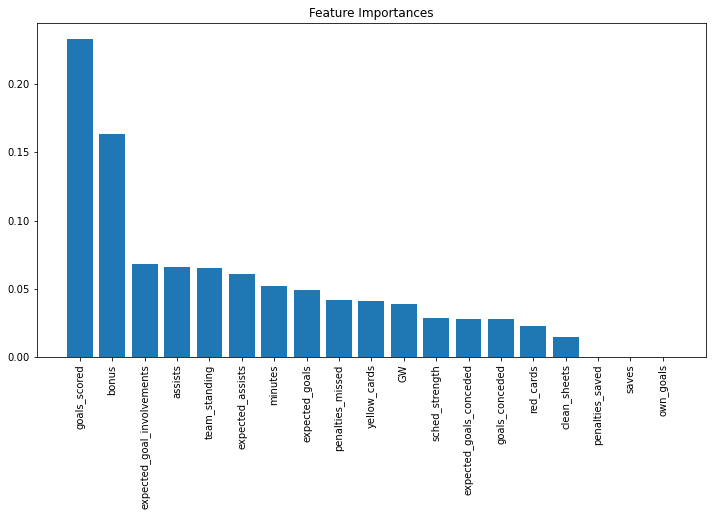

In [10]:
get_feature_importance(fwd_model, X_train_fwd)

### MID Model Performance 

In [11]:
eval_model(mid_model, X_test_mid, y_test_mid)

rmse: 1.46
R2 score: 0.42


1. team_standing: 0.10309629142284393
2. goals_scored: 0.09754335880279541
3. expected_assists: 0.07332158833742142
4. expected_goal_involvements: 0.06941796094179153
5. assists: 0.06310799717903137
6. bonus: 0.062894307076931
7. expected_goals_conceded: 0.06000690907239914
8. expected_goals: 0.059877388179302216
9. minutes: 0.057431355118751526
10. yellow_cards: 0.05236652120947838
11. GW: 0.051664888858795166
12. goals_conceded: 0.05060368403792381
13. sched_strength: 0.04813550412654877
14. own_goals: 0.04615585878491402
15. clean_sheets: 0.045949213206768036
16. red_cards: 0.0340828038752079
17. penalties_missed: 0.02434440702199936
18. penalties_saved: 0.0
19. saves: 0.0


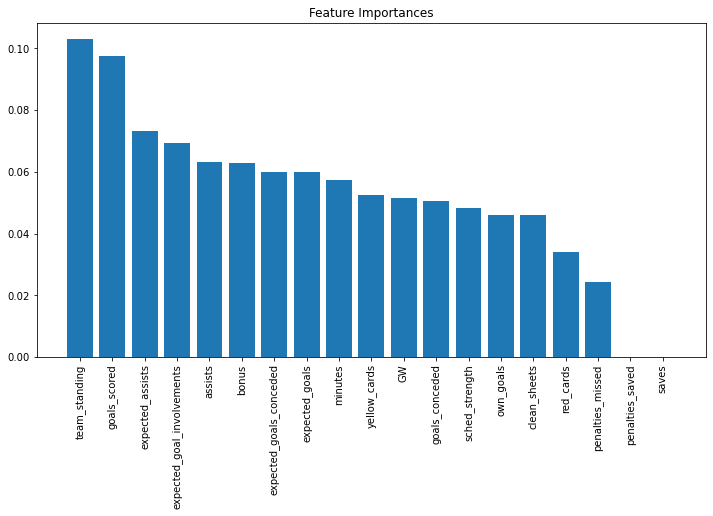

In [12]:
get_feature_importance(mid_model, X_train_mid)

### DEF Model Performance 

In [13]:
eval_model(def_model, X_test_def, y_test_def)

rmse: 1.25
R2 score: 0.51


1. team_standing: 0.1159675121307373
2. red_cards: 0.07960426062345505
3. assists: 0.0775580182671547
4. expected_goals_conceded: 0.06633005291223526
5. expected_goals: 0.06526211649179459
6. expected_assists: 0.06198962777853012
7. sched_strength: 0.06130185350775719
8. GW: 0.059205666184425354
9. clean_sheets: 0.057627949863672256
10. yellow_cards: 0.05433926358819008
11. bonus: 0.053800731897354126
12. own_goals: 0.05272633954882622
13. minutes: 0.049845993518829346
14. goals_scored: 0.049392152577638626
15. goals_conceded: 0.04938214644789696
16. expected_goal_involvements: 0.04566638171672821
17. penalties_missed: 0.0
18. penalties_saved: 0.0
19. saves: 0.0


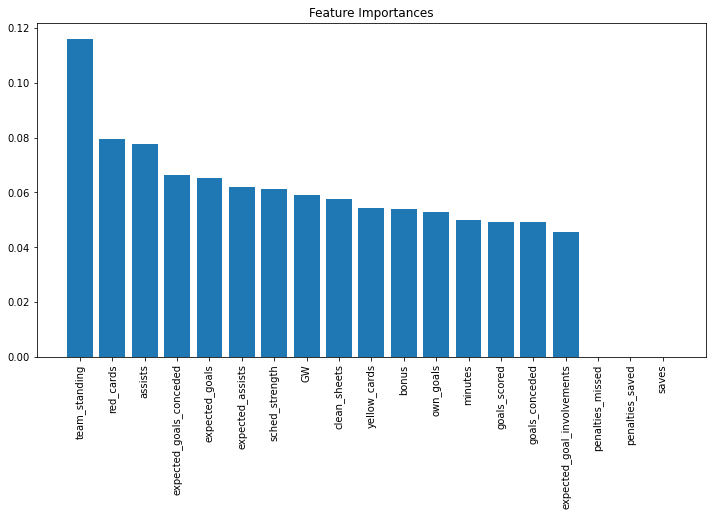

In [14]:
get_feature_importance(def_model, X_train_def)

### GK Model Performance 

In [15]:
eval_model(gk_model, X_test_gk, y_test_gk)

rmse: 1.07
R2 score: 0.58


1. expected_goals: 0.19866327941417694
2. own_goals: 0.15959979593753815
3. minutes: 0.09402597695589066
4. penalties_saved: 0.07234879583120346
5. team_standing: 0.06361603736877441
6. assists: 0.047159984707832336
7. expected_assists: 0.04236714914441109
8. yellow_cards: 0.039924077689647675
9. sched_strength: 0.03895632550120354
10. goals_conceded: 0.038464222103357315
11. GW: 0.03795970603823662
12. saves: 0.03686586394906044
13. expected_goal_involvements: 0.03504940867424011
14. expected_goals_conceded: 0.03315475955605507
15. bonus: 0.03231878578662872
16. clean_sheets: 0.024185558781027794
17. red_cards: 0.005340245086699724
18. penalties_missed: 0.0
19. goals_scored: 0.0


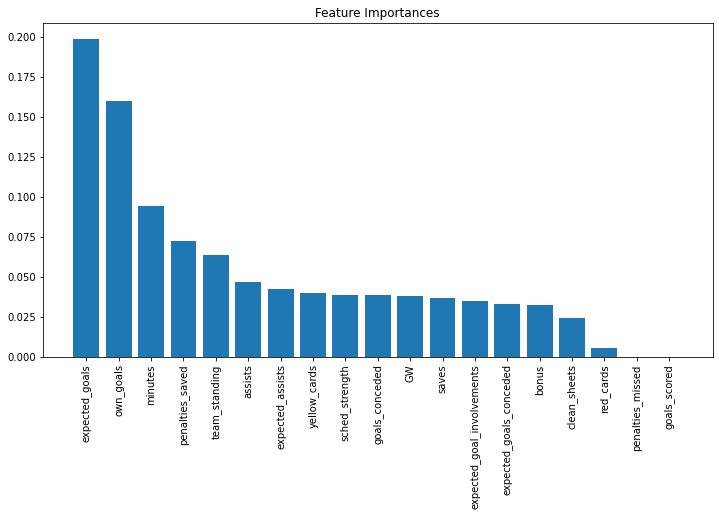

In [16]:
get_feature_importance(gk_model, X_train_gk)

# Save Models 

In [18]:
fwd_model.save_model("../../data/models/fwd_model.json")
mid_model.save_model("../../data/models/mid_model.json")
def_model.save_model("../../data/models/def_model.json")
gk_model.save_model("../../data/models/gk_model.json")